In [1]:
# Imports
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision

import matplotlib.pyplot as plt

import numpy as np

from pyro.distributions.relaxed_straight_through import RelaxedBernoulliStraightThrough

import autoencoders

from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_mse as mse
from skimage.measure import compare_psnr as psnr
from skimage.measure import compare_nrmse as nrmse

In [2]:
# Set seed for reproduciblity
torch.manual_seed(7212)
np.random.seed(2980)

In [3]:
# Mnist digits dataset (download if necessary)
test_data = torchvision.datasets.FashionMNIST(
    root='./Datasets/fashion-mnist/',
    train=False,
    transform=torchvision.transforms.ToTensor(),                        
    download=False,
)

In [4]:
# Select which device to use, use the gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Currently running on:", device)

Currently running on: cuda


In [5]:
def load_autoencoder(model_name, saved_as=None, run_on="cpu"):
    
    # Set the save name to the model name if no name was specified
    if not saved_as:
        saved_as = model_name
    
    # Select what type of autoencoder to load
    used_autoencoder = getattr(autoencoders, model_name)
    autoencoder = used_autoencoder().to(run_on)

    # Load the weights from the saved file
    autoencoder.load_state_dict(torch.load("./Trained Models/" + saved_as + ".pt", ))
    
    # Set the training flag to False
    autoencoder.eval()
    
    print("Loaded:", model_name, "| In Cuda:", next(autoencoder.parameters()).is_cuda)
    return autoencoder

In [6]:
incremental_autoencoder = load_autoencoder("IncrementalAutoEncoder", run_on=device)
random_autoencoder = load_autoencoder("RandomAutoEncoder", run_on=device)
autoencoder = load_autoencoder("AutoEncoder", run_on=device)

Loaded: IncrementalAutoEncoder | In Cuda: True
Loaded: RandomAutoEncoder | In Cuda: True
Loaded: AutoEncoder | In Cuda: True


In [7]:
def autoencoder_corruption(autoencoder):
    
    test_images = test_data.data.view(-1, 28*28).type(torch.FloatTensor).to(device)/255
    
    n_images = len(test_images)
    
#     encoded_images, decoded_images = autoencoder(test_images)

    encoded_images = autoencoder.encoder(test_images)
    binary_encoded = RelaxedBernoulliStraightThrough(1, logits=encoded_images).rsample()
    
    x,y = binary_encoded.shape
    
    for k in range(0, y+1, 8):
        print("Current corruption:", k)
        
        mask = np.where(np.concatenate((np.zeros((x,y-k)), np.ones((x, k))), axis=1))
        binary_encoded[mask] = torch.distributions.Bernoulli(probs=(torch.ones(x,y)/2)).sample().to(device)[mask]

        decoded_images = autoencoder.decoder(binary_encoded)
        
        total_mse, total_ssim, total_nrmse, total_psnr = 0, 0, 0, 0 
    
        for i in range(n_images):
            test_image = test_images[i].cpu().detach().numpy()
            decoded_test_image = decoded_images[i].cpu().detach().numpy()
            if i == 256:
                plt.clf()
                plt.imshow(np.reshape(decoded_test_image, (28,28)), cmap='gray')
                plt.show(); plt.pause(0.05)
            total_mse += mse(test_image, decoded_test_image)
            total_ssim += ssim(test_image, decoded_test_image)
            total_nrmse += nrmse(test_image, decoded_test_image)
            total_psnr += psnr(test_image, decoded_test_image)

        value_mse = total_mse/n_images
        value_ssim = total_ssim/n_images
        value_nrmse = total_nrmse/n_images
        value_psnr = total_psnr/n_images

        print("MSE:", value_mse, "SSIM:", value_ssim, "NRMSE:", value_nrmse, "PSNR:", value_psnr)

Current corruption: 0


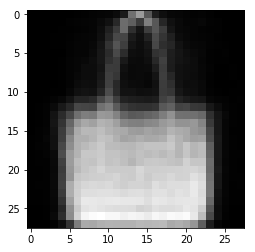

MSE: 0.020172986028902842 SSIM: 0.6827972592986662 NRMSE: 0.3445529666404924 PSNR: 17.594020590353413
Current corruption: 8


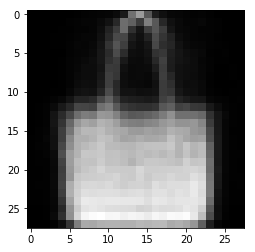

MSE: 0.020172824322659575 SSIM: 0.6827746298190768 NRMSE: 0.3444746153054098 PSNR: 17.594733207450258
Current corruption: 16


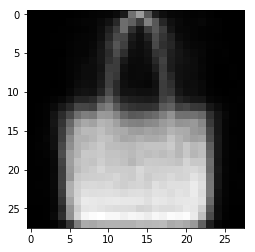

MSE: 0.020176770294265872 SSIM: 0.6827411538602041 NRMSE: 0.34450228988632914 PSNR: 17.594177942727242
Current corruption: 24


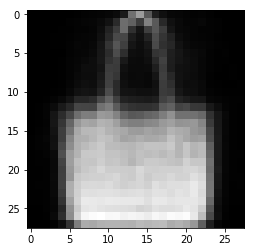

MSE: 0.020166236470653413 SSIM: 0.6826692721743225 NRMSE: 0.3444792274637843 PSNR: 17.596650487315397
Current corruption: 32


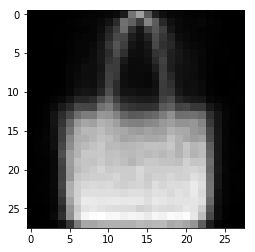

MSE: 0.0201809605217631 SSIM: 0.6824791205631056 NRMSE: 0.3445605036261986 PSNR: 17.593396379079692
Current corruption: 40


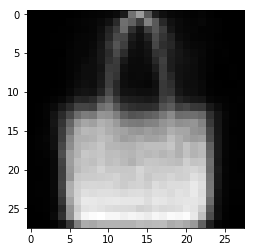

MSE: 0.02019516551232228 SSIM: 0.6823990420592752 NRMSE: 0.3446430606469914 PSNR: 17.59019599581544
Current corruption: 48


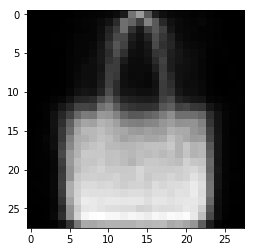

MSE: 0.020207541986248467 SSIM: 0.682202655154232 NRMSE: 0.34477381883003827 PSNR: 17.58722308775904
Current corruption: 56


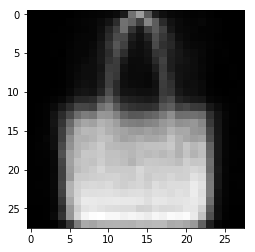

MSE: 0.020223082608689897 SSIM: 0.6818129360130656 NRMSE: 0.3449179001101201 PSNR: 17.583664529881815
Current corruption: 64


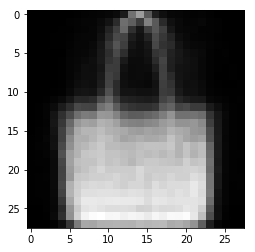

MSE: 0.02023375798153652 SSIM: 0.6817254903676475 NRMSE: 0.34501755069115664 PSNR: 17.580688009754695
Current corruption: 72


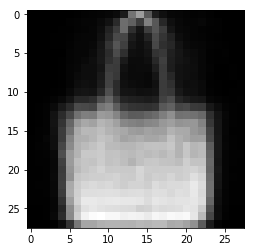

MSE: 0.020259228562247315 SSIM: 0.6815398810472231 NRMSE: 0.34511656333115265 PSNR: 17.576216641453183
Current corruption: 80


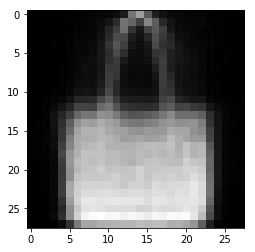

MSE: 0.02028960492796588 SSIM: 0.6813194127504114 NRMSE: 0.34542179020514036 PSNR: 17.56702442460696
Current corruption: 88


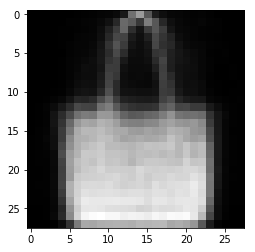

MSE: 0.020297444945600967 SSIM: 0.680847837920078 NRMSE: 0.3455248120166281 PSNR: 17.566229179187058
Current corruption: 96


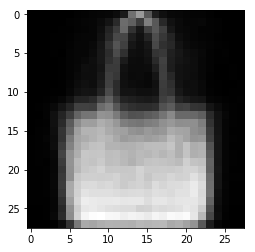

MSE: 0.02034494562234492 SSIM: 0.6804000228742614 NRMSE: 0.3459763979782654 PSNR: 17.55441240181066
Current corruption: 104


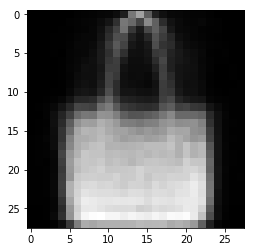

MSE: 0.020395607032083422 SSIM: 0.6798508779878918 NRMSE: 0.34634656881511805 PSNR: 17.542551643630937
Current corruption: 112


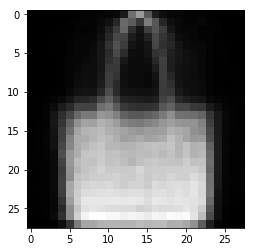

MSE: 0.02043728409018545 SSIM: 0.6792442816786037 NRMSE: 0.3468158603758597 PSNR: 17.532141778350233
Current corruption: 120


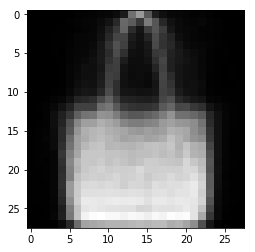

MSE: 0.02048478126028291 SSIM: 0.6785545493536633 NRMSE: 0.3472076559002713 PSNR: 17.521486673810976
Current corruption: 128


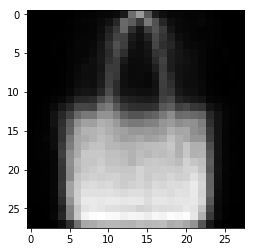

MSE: 0.020534593890441863 SSIM: 0.6774602024290552 NRMSE: 0.3476723658753357 PSNR: 17.509686892435525
Current corruption: 136


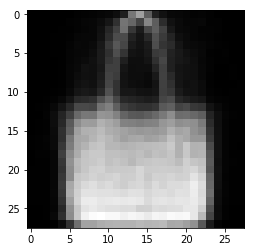

MSE: 0.020645043388971152 SSIM: 0.6763439782549395 NRMSE: 0.34873497189432384 PSNR: 17.481978533697365
Current corruption: 144


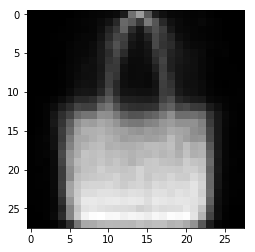

MSE: 0.020739782071971573 SSIM: 0.6756148727608703 NRMSE: 0.3496526904237553 PSNR: 17.4599735161437
Current corruption: 152


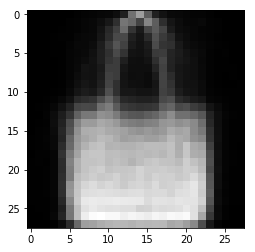

MSE: 0.02085252099788221 SSIM: 0.6738774741635065 NRMSE: 0.35056302998741057 PSNR: 17.435310143354254
Current corruption: 160


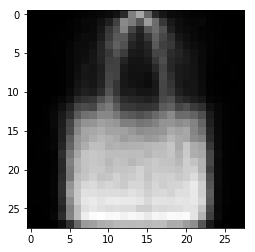

MSE: 0.020988330498932416 SSIM: 0.673564952420137 NRMSE: 0.35169444933866745 PSNR: 17.402667372649276
Current corruption: 168


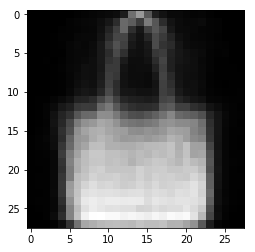

MSE: 0.021167729893586274 SSIM: 0.6713183539548341 NRMSE: 0.35334693819348517 PSNR: 17.359497377005688
Current corruption: 176


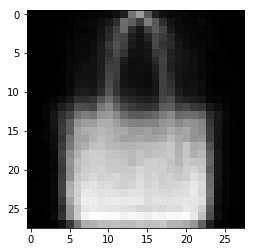

MSE: 0.021400715407135444 SSIM: 0.6684552357341006 NRMSE: 0.3554019157780403 PSNR: 17.309291935509776
Current corruption: 184


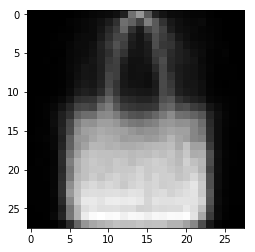

MSE: 0.02169330744570586 SSIM: 0.6661353858378866 NRMSE: 0.35785944485207116 PSNR: 17.24501437812575
Current corruption: 192


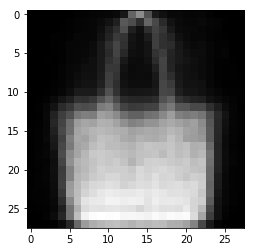

MSE: 0.022036441450539148 SSIM: 0.6627287243436738 NRMSE: 0.36063645681418605 PSNR: 17.17042832270412
Current corruption: 200


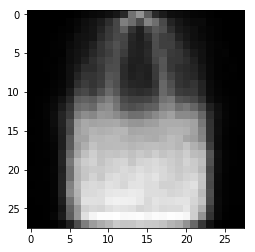

MSE: 0.022713772157517815 SSIM: 0.6564384118366036 NRMSE: 0.36633592260449854 PSNR: 17.026013507999988
Current corruption: 208


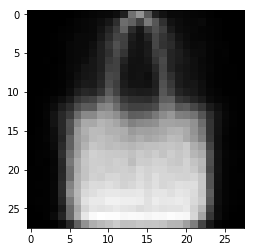

MSE: 0.023419153697915657 SSIM: 0.6489600321904918 NRMSE: 0.37226617379817767 PSNR: 16.878855117344465
Current corruption: 216


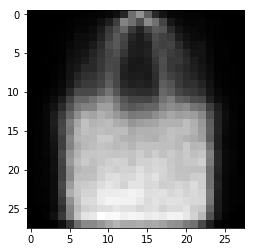

MSE: 0.02452630227451873 SSIM: 0.6353512631863764 NRMSE: 0.3811637897079618 PSNR: 16.662892735423505
Current corruption: 224


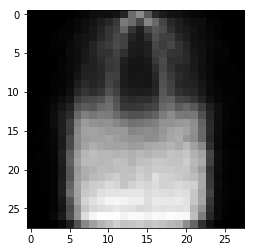

MSE: 0.026288297230008414 SSIM: 0.6172709457475729 NRMSE: 0.3948421244193781 PSNR: 16.346277092291317
Current corruption: 232


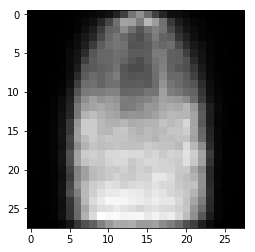

MSE: 0.028987052752710428 SSIM: 0.5903310708117767 NRMSE: 0.41396566731037027 PSNR: 15.897878343525244
Current corruption: 240


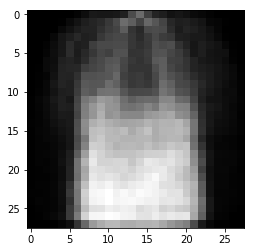

MSE: 0.03416735873185887 SSIM: 0.546693522439865 NRMSE: 0.4481324217467113 PSNR: 15.17544804244984
Current corruption: 248


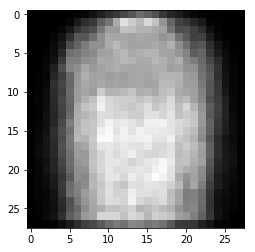

MSE: 0.04774992059795941 SSIM: 0.47306592259924846 NRMSE: 0.5317403131670914 PSNR: 13.69774047390809
Current corruption: 256


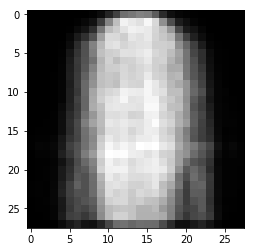

MSE: 0.11370370483086417 SSIM: 0.2505772612175896 NRMSE: 0.8313363802344171 PSNR: 9.976238446465286


In [8]:
autoencoder_corruption(incremental_autoencoder)